In [1]:
%matplotlib inline

# Machine learning your way to analyzing MEG/EEG data

by `Mainak Jas`

# Multivariate (machine learning) vs Univariate (T stats etc.)

![](univariate_vs_multivariate.png)

# First we go from raw to evoked

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


The subsequent decoding analyses only capture evoked responses, so we can
low-pass the MEG data. Usually a value more like 40 Hz would be used,
but here low-pass at 20 so we can more heavily decimate, and allow
the examlpe to run faster. The 2 Hz high-pass helps improve CSP.

In [2]:
raw.filter(2, 20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 991 samples (1.650 sec)



<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~482.1 MB, data loaded>

In [4]:
events = mne.find_events(raw, 'STI 014')

320 events found
Event IDs: [ 1  2  3  4  5 32]


In [98]:
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

In [5]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG

145 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
3 projection items activated
Loading data for 145 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    R

<Epochs  |   123 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~11.5 MB, data loaded,
 'Auditory/Left': 56
 'Visual/Left': 67>

# Now comes the machine learning ...

For machine learning, we need:
* Features/data ``X`` 
* Target labels ``y``

We have:

In [8]:
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

print(X.shape)
print(y.shape)

(123, 203, 43)
(123,)


Scikit-learn and MNE come with:
* Transformers to manipulate the data `X`
* Estimators to learn something from the data `X` with `y` and make predictions

An example of transformer ...

In [9]:
from mne.decoding import Scaler

scaler = Scaler(epochs.info)
scaler.fit(X)
X_scaled = scaler.transform(X)

You can also chain the ``fit`` and ``transform``

In [10]:
X_scaled = scaler.fit(X).transform(X)

or use the shorthand notation

In [11]:
X_scaled = scaler.fit_transform(X)

This did something similar to whitening. Different channel types were brought to same scale.

In [12]:
print(X.max())
print(X_scaled.max())

5.224902655884485e-11
522.4902655884484


Another transformer which reshapes the data so that all the channels are concatenated along the last axis

In [13]:
from mne.decoding import Vectorizer

vec = Vectorizer()
X_scaled_reshaped = vec.fit_transform(X_scaled)

In [14]:
print(X_scaled.shape)
print(X_scaled_reshaped.shape)

(123, 203, 43)
(123, 8729)


Now, we can use this to classify our data

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_scaled_reshaped, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
clf.predict(X_scaled_reshaped)

array([3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3,
       1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1])

Or you can check how well you did ...

In [17]:
clf.score(X_scaled_reshaped, y)

1.0

Why did we do so well?

Because we predicted on the same data that we learned from ...

In other words, this was too easy

That's why you need to split your data into two parts:
* Training set, on which you learn something
* Test set, on which you check performance

Let's try again, fitting on all but the first 10 trials and scoring on first 10 trials

In [18]:
clf.fit(X_scaled_reshaped[10:], y[10:])
clf.score(X_scaled_reshaped[:10], y[:10]) 

1.0

But we could have done well just by chance

So actually what you need to do is to split the data multiple times using "cross-validation" and average the scores

In [20]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)
for train, test in cv.split(X_scaled_reshaped):
    clf.fit(X_scaled_reshaped[train], y[train])
    accuracy = clf.score(X_scaled_reshaped[test], y[test])
    print(accuracy)

1.0
1.0
1.0
0.9583333333333334
1.0


here the accuracy is still high because it's easy! But at least you see it's not always 1.0

There are many different strategies you can split ...

* Shuffle split
* Stratified K fold
* Leave one out
* Group K fold

In [21]:
from sklearn.model_selection import ShuffleSplit, GroupKFold, LeaveOneOut

You don't actually need to do the loop!

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_scaled_reshaped, y, cv=cv)

array([1.        , 1.        , 1.        , 0.95833333, 1.        ])

The nice thing is that you can switch your classifier with another one and the rest of your code remains the same

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_scaled_reshaped, y)
clf.predict(X_scaled_reshaped)

array([3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3,
       1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1])

# Pipelines

In scikit-learn, you can chain together any number of transformers and optionally an estimator to form a pipeline

In [25]:
from sklearn.pipeline import make_pipeline

clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression())

The pipeline works just as a regular classifier

In [26]:
clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', Scaler(info=<Info | 24 non-empty fields
    acq_pars : str | 13886 items
    bads : list | 0 items
    ch_names : list | MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, ...
    chs : list | 203 items (GRAD: 203)
    comps : list | 0 items
    custom_ref_applied : bool | False
   ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [27]:
scores = cross_val_score(clf, X, y, cv=5, n_jobs=1)
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 99.2%


# SlidingEstimator or time resolved decoding

Now, we can use the same strategy to fit a classifier per time point using `SlidingEstimator`

In [49]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator, cross_val_multiscore

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


Then we can get the mean scores across cross-validation splits and plot it across time

Text(0.5, 1.0, 'Sensor space decoding')

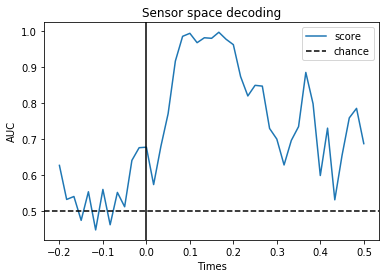

In [51]:
scores_mean = np.mean(scores, axis=0)

fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

“Time-resolved classifiers using a 20 ms moving window exceeded chance level at 51 ms (the later edge of the window) for spatial frequency, 65 ms for orientation, and 98 ms for rotation direction.”

![](time_resolved.png)

[Ramkumar, Jas, Pannasch, Hari, Parkkonen, J. Neuroscience (2013)]

We can also plot the estimated coefficients of the classifier if it's a linear model ...

In [35]:
from mne.decoding import LinearModel, get_coef

clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

[........................................] 100.00% Fitting SlidingEstimator |  


<SlidingEstimator(base_estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearmodel', LinearModel(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)))]),
         n_jobs=1, scoring='roc_auc', verbose=True, fitted with 43 estimators>

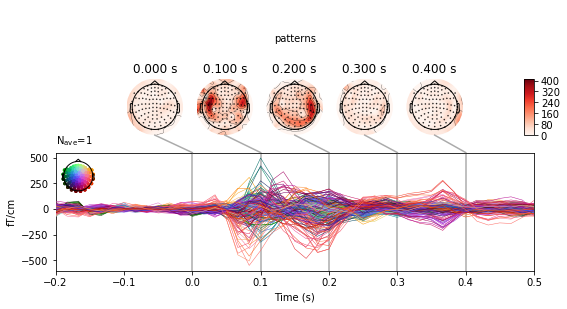

In [37]:
coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                  **joint_kwargs);

# Temporal Generalization

[King, Gramfort, Schurger, Naccache, Dehaene (2014) PLoS One]

... and many other publications by King et al.

In [45]:
from mne.decoding import GeneralizingEstimator

time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato
[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato
[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato
[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato
[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato


Then, we plot this

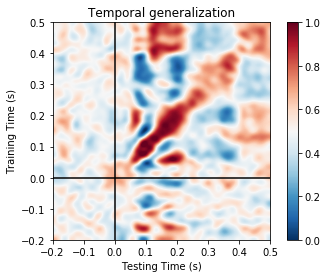

In [46]:
mean_scores = np.mean(scores, axis=0)

fig, ax = plt.subplots(1, 1)

scores
im = ax.imshow(mean_scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

# Common Spatial Pattern

used in the context of BCI

In [47]:
from mne.decoding import CSP

csp = CSP(n_components=3, norm_trace=False)
clf = make_pipeline(csp, LogisticRegression(solver='lbfgs'))
scores = cross_val_score(clf, X, y, cv=5, n_jobs=1)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

Computing data rank from raw with rank=None
    Using tolerance 4.3e-11 (2.2e-16 eps * 203 dim * 9.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps * 203 dim * 1.1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 4.2e-11 (2.2e-16 eps * 203 dim * 9.3e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps * 203 